### Transfer Learning Feature Extraction part1:

In [ ]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref= zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-02-11 12:31:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.159.128, 74.125.126.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.159.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   221MB/s    in 0.7s    

2022-02-11 12:31:57 (221 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
import os

for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}. ")

There are 2 directories and 0 images in 10_food_classes_10_percent. 
There are 10 directories and 0 images in 10_food_classes_10_percent/test. 
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger. 
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice. 
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak. 
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream. 
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon. 
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings. 
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi. 
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza. 
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen. 
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE=(224,224)
BATCH_SIZE= 32

train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

train_datagen= ImageDataGenerator(rescale=1/255.)
test_datagen= ImageDataGenerator(rescale=1/255.)

train_data_10_percent= train_datagen.flow_from_directory(train_dir,
                                                           target_size=IMAGE_SHAPE,
                                                           batch_size=BATCH_SIZE,
                                                           class_mode="categorical")
test_data= test_datagen.flow_from_directory(test_dir,
                                                           target_size=IMAGE_SHAPE,
                                                           batch_size=BATCH_SIZE,
                                                           class_mode="categorical")


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## The Callbacks
* Tracing Experiments
* Model Checkpoint
* prevent overfitting

In [ ]:
# Function for callbacks
from datetime import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir= dir_name+"/"+experiment_name+"/"+datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


### Creating models with using 
* TensorFlow HUB
* paperswithcode
* ImageNet

https://tfhub.dev/google/efficientnet/b0/feature-vector/1

In [ ]:
# comparing models
efficientnet_url="https://tfhub.dev/google/efficientnet/b0/feature-vector/1"
resnet_url= "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
mobil_net="https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
xxnet= "https://tfhub.dev/google/supcon/resnet_v1_200/imagenet/classification/1"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
def create_model(model_url,num_classes=10):
  """
  This function takes Tensorflow Hub URL and creates model
  model_url(str)
  num_classes(int): targeted class bumber
  it return a sequential model
  """
  feature_extractor_layer= hub.KerasLayer(model_url,
                                          trainable=False,
                                          name="feature_extracter_layer",
                                          input_shape=IMAGE_SHAPE+(3,))
  #create a model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax",name="output_layer")
  ])
  return model

In [ ]:
#Create resnet model 
xxnet_model= create_model(xxnet_url,
                          10)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extracter_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
xxnet_model.compile(loss= "categorical_crossentropy",
                     optimizer= tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
#Fitting the model
xxnet_history= xxnet_model.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data= test_data,
                                 validation_steps=len(test_data),
                                 callbacks=[create_tensorboard_callback(dir_name="tesnsorflow_hub",
                                                                       experiment_name="resnet50v2")])

Saving TensorBoard log files to: tesnsorflow_hub/resnet50v2/20220211-123250
Epoch 1/5
24/24 [==============================] - 37s 1s/step - loss: 1.9606 - accuracy: 0.3507 - val_loss: 1.1725 - val_accuracy: 0.6256
Epoch 2/5
24/24 [==============================] - 23s 989ms/step - loss: 0.9129 - accuracy: 0.7253 - val_loss: 0.8356 - val_accuracy: 0.7288
Epoch 3/5
24/24 [==============================] - 21s 912ms/step - loss: 0.6301 - accuracy: 0.8147 - val_loss: 0.7329 - val_accuracy: 0.7592
Epoch 4/5
24/24 [==============================] - 22s 924ms/step - loss: 0.4792 - accuracy: 0.8747 - val_loss: 0.6894 - val_accuracy: 0.7820
Epoch 5/5
24/24 [==============================] - 21s 896ms/step - loss: 0.3810 - accuracy: 0.9093 - val_loss: 0.6581 - val_accuracy: 0.7836


### Power of Transfer Learning

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):

  loss= history.history["loss"]
  val_loss= history.history["val_loss"]

  accuracy= history.history["accuracy"]
  val_accuracy= history.history["val_accuracy"]
  epochs=range(len(history.history["loss"]))
  #plot loss
  plt.plot(epochs, loss, label="Training_Loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend();

   #plot loss
  plt.figure()
  plt.plot(epochs, accuracy, label="Training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("Epochs")
  plt.legend();

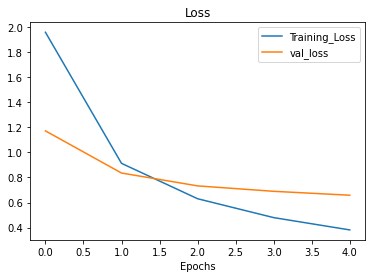

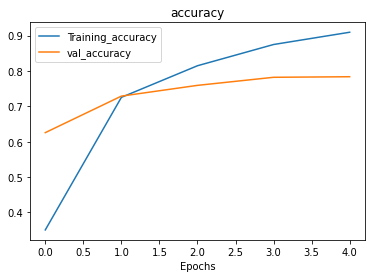

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
#Create resnet model 
efficientnet_model= create_model(efficientnet_url,
                          10)

efficientnet_model.compile(loss= "categorical_crossentropy",
                     optimizer= tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

#Fitting the model
efficientnet_history= efficientnet_model.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data= test_data,
                                 validation_steps=len(test_data),
                                 callbacks=[create_tensorboard_callback(dir_name="tesnsorflow_hub",
                                                                       experiment_name="efficientnet")])

Saving TensorBoard log files to: tesnsorflow_hub/efficientnet/20220211-123743
Epoch 1/5
24/24 [==============================] - 25s 854ms/step - loss: 1.8423 - accuracy: 0.4213 - val_loss: 1.2814 - val_accuracy: 0.7248
Epoch 2/5
24/24 [==============================] - 20s 864ms/step - loss: 1.0605 - accuracy: 0.7693 - val_loss: 0.8625 - val_accuracy: 0.8156
Epoch 3/5
24/24 [==============================] - 18s 784ms/step - loss: 0.7593 - accuracy: 0.8440 - val_loss: 0.6930 - val_accuracy: 0.8396
Epoch 4/5
24/24 [==============================] - 18s 772ms/step - loss: 0.6060 - accuracy: 0.8707 - val_loss: 0.6084 - val_accuracy: 0.8524
Epoch 5/5
24/24 [==============================] - 18s 780ms/step - loss: 0.5122 - accuracy: 0.8947 - val_loss: 0.5557 - val_accuracy: 0.8572


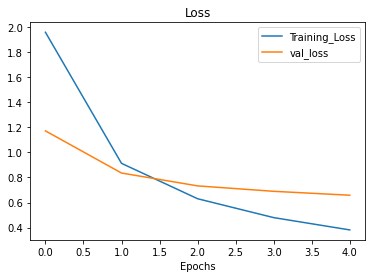

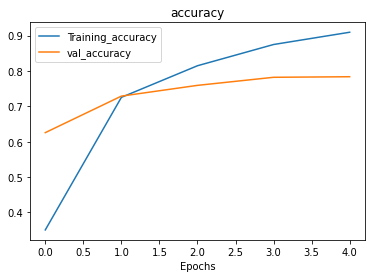

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extracter_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


## Comparing Results with using Tensorboard

In [ ]:
#TensorBoard
!tensorboard dev upload --logdir ./tesnsorflow_hub/ \
  --name "Efficient vs Resnet" \
  --description "Comparing 2 tf Hub feature extraction model"\
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tesnsorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=5dAxs2ZUcfuCzRNubj68kjb6VzSNdz&prompt=consent&access_type=of

### The tensor board is cool but it does not accept private datas so be carefull when you use it
https://tensorboard.dev/experiment/RdpUKC9mS4qyMkzPNZgfpw/ 

* weight and biases can be replaced with tensorboard

In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/RdpUKC9mS4qyMkzPNZgfpw/
	Name                 Efficient vs Resnet
	Description          Comparing 2 tf Hub feature extraction model
	Id                   RdpUKC9mS4qyMkzPNZgfpw
	Created              2022-02-11 12:56:22 (4 minutes ago)
	Updated              2022-02-11 12:56:24 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3138469
Total: 1 experiment(s)


# Yeni Bölüm

In [ ]:
#delete and experiment
!tensorboard dev delete --experiment_id RdpUKC9mS4qyMkzPNZgfpw

Deleted experiment RdpUKC9mS4qyMkzPNZgfpw.
